# **IMAGE PROCESSING** 📉

In [43]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import random
import shutil
import tensorflow as tf
from os import getcwd
from os import listdir
import cv2
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
import imutils
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/PRI Final Project dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [44]:
print(len(os.listdir('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train')))
print(len(os.listdir('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train')))

38
38


In [42]:
TRAINING_DIR = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [46]:
x_train=train_datagen.flow_from_directory(r"/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",target_size=(128,128),
                                        class_mode='categorical',batch_size=24)

Found 70295 images belonging to 38 classes.


(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

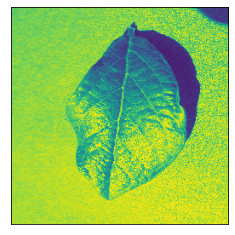

In [23]:
img = cv2.imread('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Blueberry___healthy/02aa57b8-95c2-49a0-a8ee-4ec96bb966da___RS_HL 0500_180deg.JPG', 0)
plt.imshow(img), plt.grid(False)
plt.xticks([]), plt.yticks([])

# HISTOGRAM

Text(0, 0.5, 'Frequency')

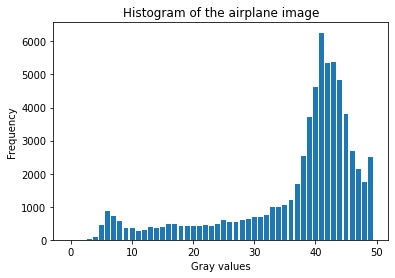

In [8]:
hist = cv2.calcHist([img],[0],None,[50],[0,256])

# different methods for displaying a histogram
plt.bar(range(50), hist.ravel())
plt.title('Histogram of the airplane image')
plt.xlabel('Gray values')
plt.ylabel('Frequency')

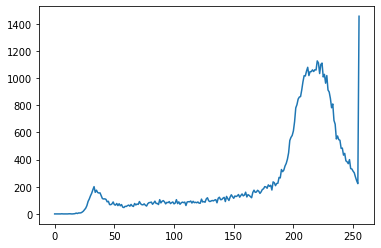

In [9]:
hist,bins = np.histogram(img.ravel(),256,[0,256])
plt.plot(hist)

In [12]:
high = cv2.imread('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Cherry_(including_sour)___Powdery_mildew/00b7df55-c789-43d6-a02e-a579ac9d07e6___FREC_Pwd.M 4748.JPG')
low = cv2.imread('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Cherry_(including_sour)___Powdery_mildew/02a749ab-890a-4165-9f17-c1e30a56ef41___FREC_Pwd.M 4868.JPG')

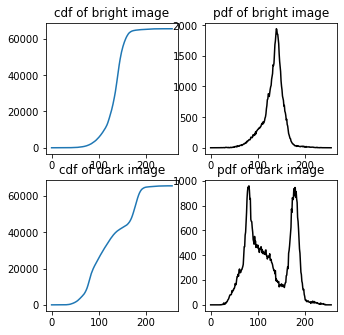

In [13]:
hist_high = cv2.calcHist([high],[2],None,[256],[0,256])
hist_low = cv2.calcHist([low],[2],None,[256],[0,256])

cdf_low = hist_low.cumsum()
cdf_high = hist_high.cumsum()

# plot cumulative histograms
plt.subplot(221), plt.plot(cdf_high), plt. title('cdf of bright image')
plt.subplot(222), plt.plot(hist_high, 'k'), plt. title('pdf of bright image')

plt.subplot(223), plt.plot(cdf_low), plt. title('cdf of dark image')
plt.subplot(224), plt.plot(hist_low, 'k'), plt. title('pdf of dark image')

# adjust the placement of subplots
plt.subplots_adjust(bottom=2, right=0.8, top=3)

plt.show()

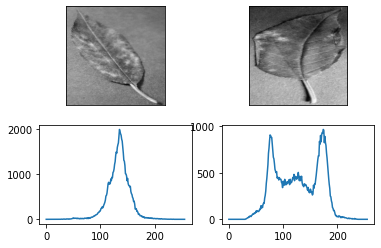

In [14]:
low_gray = cv2.cvtColor(low, cv2.COLOR_BGR2GRAY)
high_gray = cv2.cvtColor(high, cv2.COLOR_BGR2GRAY)
# show images and their histograms
plt.subplot(221), plt.imshow(high_gray, cmap='gray')
plt.grid(False), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.plot(cv2.calcHist([high_gray],[0],None,[256],[0,256]))

plt.subplot(222), plt.imshow(low_gray, cmap='gray')
plt.grid(False), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.plot(cv2.calcHist([low_gray],[0],None,[256],[0,256]))

plt.show()

# CONTRAST

In [16]:
def manip_image(image, alpha, beta):
  
  new_image = np.zeros(image.shape, image.dtype)
  
  for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        new_image[y,x] = np.clip(alpha*image[y,x] + beta, 0, 255)
  
  return new_image

(0.0, 1750.0)

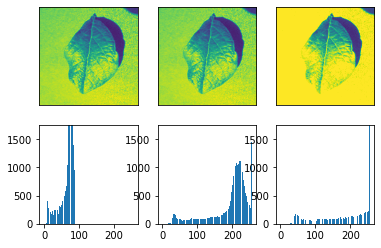

In [24]:
increase_contrast = manip_image(img, 1.35, 0)
decrease_contrast = manip_image(img, 0.35, 0)

# Compare the results
plt.figure()
plt.subplot(231), plt.imshow(decrease_contrast)
plt.grid(False), plt.xticks([]), plt.yticks([])

plt.subplot(232), plt.imshow(img)
plt.grid(False), plt.xticks([]), plt.yticks([])


plt.subplot(233),plt.imshow(increase_contrast)
plt.grid(False), plt.xticks([]), plt.yticks([])

plt.subplot(234)
plt.bar(range(256), 
        cv2.calcHist([decrease_contrast],[0],None,[256],[0,256]).ravel())
plt.ylim((0, 1750))

plt.subplot(235)
plt.bar(range(256),
        cv2.calcHist([img],[0],None,[256],[0,256]).ravel())
plt.ylim((0, 1750))

plt.subplot(236)
plt.bar(range(256),
        cv2.calcHist([increase_contrast],[0],None,[256],[0,256]).ravel())
plt.ylim((0, 1750))

# **SPACIAL FILTERING**

ORIGINAL IMAGE 

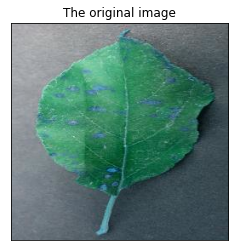

In [18]:
ref = cv2.imread('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG')
plt.imshow(ref), plt.grid(False)
plt.title('The original image')
plt.xticks([])
plt.yticks([])
plt.show()

# 1.Averaging Filter

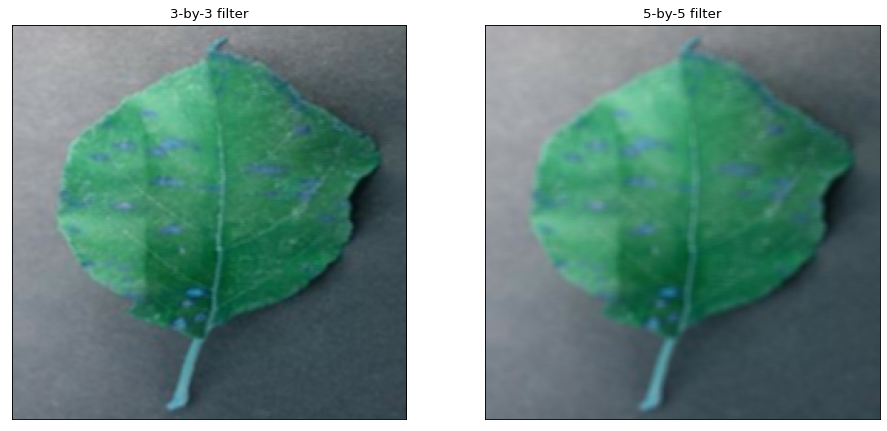

In [19]:
kernel_5 = np.ones((5,5),np.float32)/25
kernel_3 = np.ones((3,3),np.float32)/9

filtered_5 = cv2.filter2D(ref,-1,kernel_5)
filtered_3 = cv2.filter2D(ref,-1,kernel_3)
fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(121), plt.imshow(filtered_3), plt.title('3-by-3 filter')
plt.grid(False)
plt.xticks([])
plt.yticks([])

plt.subplot(122), plt.imshow(filtered_5), plt.title('5-by-5 filter')
plt.grid(False)
plt.xticks([])
plt.yticks([])

plt.show()

# 2.Padding

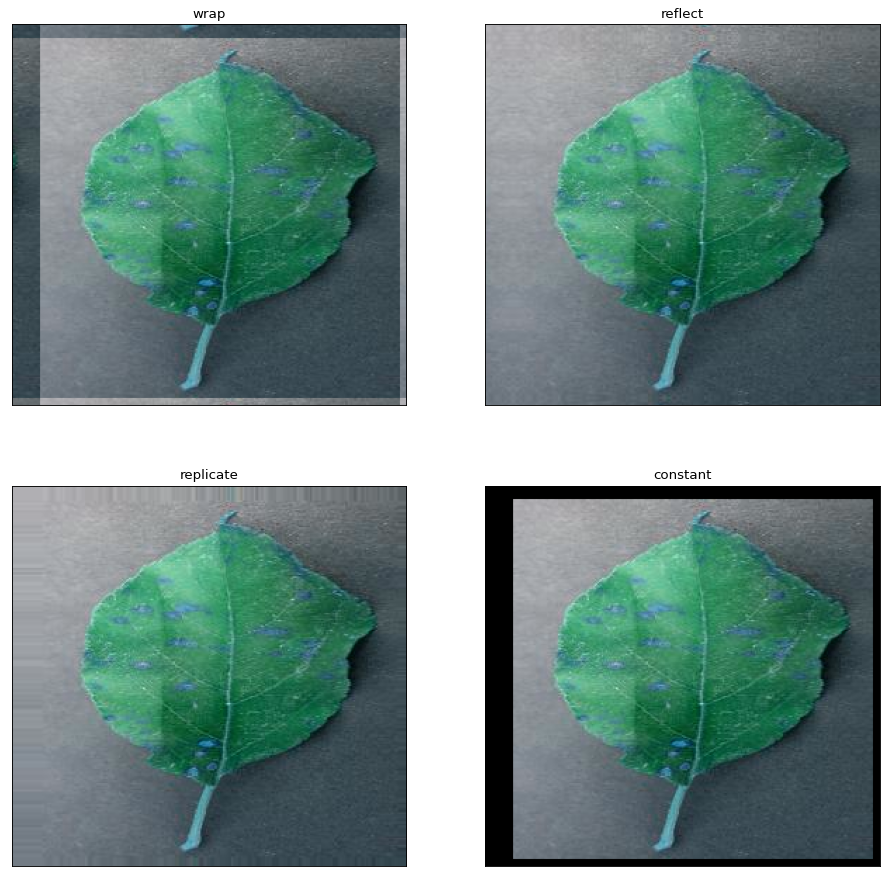

In [20]:
top = 10; bottom = 5; left = 20; right = 5
const = 100
img2 = cv2.copyMakeBorder(ref, top, bottom, left, right, 
                          cv2.BORDER_WRAP)
img3 = cv2.copyMakeBorder(ref, top, bottom, left, right, 
                          cv2.BORDER_REFLECT)
img4 = cv2.copyMakeBorder(ref, top, bottom, left, right, 
                          cv2.BORDER_REPLICATE)
img5 = cv2.copyMakeBorder(ref, top, bottom, left, right, 
                          cv2.BORDER_CONSTANT, const)

# Display the images
fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(221), plt.imshow(img2), plt.grid(False)
plt.xticks([]), plt.yticks([]), plt.title('wrap')

plt.subplot(222), plt.imshow(img3), plt.grid(False)
plt.xticks([]), plt.yticks([]), plt.title('reflect')

plt.subplot(223), plt.imshow(img4), plt.grid(False)
plt.xticks([]), plt.yticks([]), plt.title('replicate')

plt.subplot(224), plt.imshow(img5), plt.grid(False)
plt.xticks([]), plt.yticks([]), plt.title('constant')

plt.show()

(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

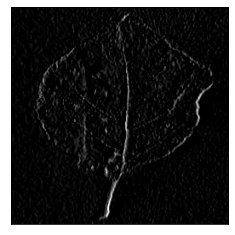

In [21]:
vertical_gd = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
filter_v = cv2.filter2D(ref[:, :, 2], -1, vertical_gd)
plt.imshow(filter_v, cmap='gray'), plt.grid(False)
plt.xticks([]), plt.yticks([])

Median Filtering

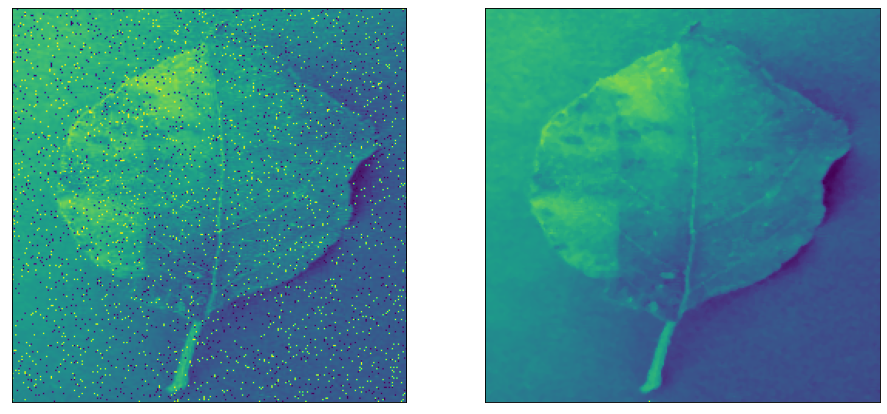

In [27]:
s_and_p = np.random.rand(ref.shape[0], ref.shape[1])
salt = s_and_p > .975
pepper = s_and_p < .025

channel_2 = np.atleast_1d(ref[:, :, 1])
noisy = np.zeros_like(channel_2)

for i in range(channel_2.shape[0]*channel_2.shape[1]):
  if salt.ravel()[i] == 1:
    noisy.ravel()[i] = 255
  elif pepper.ravel()[i] == 1:
    noisy.ravel()[i] = 0
  else:
    noisy.ravel()[i] = channel_2.ravel()[i]

Med = cv2.medianBlur(noisy, 3)

fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121), plt.xticks([]), plt.yticks([])
plt.imshow(noisy), plt.grid(False)
plt.subplot(122), plt.xticks([]), plt.yticks([])
plt.imshow(Med), plt.grid(False)
plt.show()

Gaussian Filtering

(<matplotlib.image.AxesImage at 0x7f7e41f79dd0>, None)

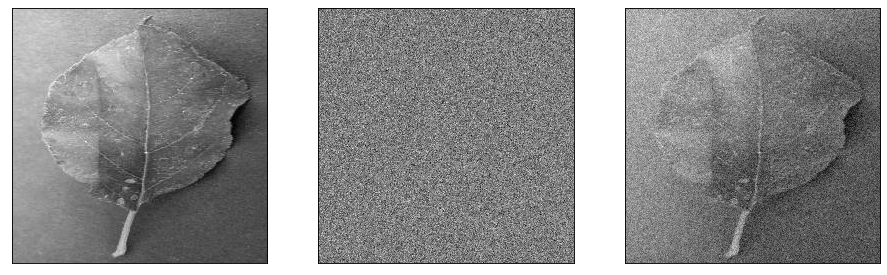

In [29]:
mean=0
sigma = 20.0
gauss_noise = np.random.normal(mean,sigma, (ref.shape[0], ref.shape[1]))

gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)

g_noisy = gray + gauss_noise

fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131), plt.xticks([]), plt.yticks([])
plt.imshow(gray, cmap='gray'), plt.grid(False)
plt.subplot(132), plt.xticks([]), plt.yticks([])
plt.imshow(gauss_noise, cmap='gray'), plt.grid(False)
plt.subplot(133), plt.xticks([]), plt.yticks([])
plt.imshow(g_noisy, cmap='gray'), plt.grid(False)

[[0.33319442]
 [0.33361117]
 [0.33319442]]


(<matplotlib.image.AxesImage at 0x7f7e40d73cd0>, None)

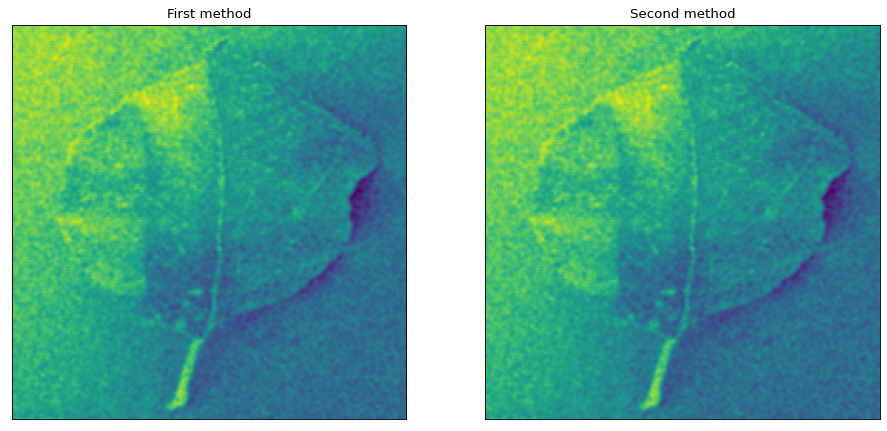

In [35]:
g_filtered = cv2.GaussianBlur(g_noisy, (3, 3), 20, 20)
g_kernel = cv2.getGaussianKernel(3, 20)
print(g_kernel)

g_filtered_2 = cv2.sepFilter2D(g_noisy, -1, g_kernel, g_kernel)

fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121), plt.xticks([]), plt.yticks([]), plt.title('First method')
plt.imshow(g_filtered), plt.grid(False)
plt.subplot(122), plt.xticks([]), plt.yticks([]), plt.title('Second method')
plt.imshow(g_filtered_2), plt.grid(False)

(<matplotlib.image.AxesImage at 0x7f7e4143d690>, None)

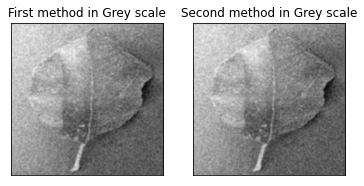

In [39]:
plt.subplot(121), plt.xticks([]), plt.yticks([]), plt.title('First method in Grey scale')
plt.imshow(g_filtered, cmap='gray'), plt.grid(False)
plt.subplot(122), plt.xticks([]), plt.yticks([]), plt.title('Second method in Grey scale')
plt.imshow(g_filtered_2, cmap='gray'), plt.grid(False)